In [104]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

-------------------------------------------------------------------------------------------------------------------------------

## Inspect Data

In [105]:
data = pd.read_csv("insurance.txt")
data.head(1)

,age,bmi,children,charges
0,19,27.9,0,16884.924


In [106]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   bmi       1338 non-null   float64
 2   children  1338 non-null   int64  
 3   charges   1338 non-null   float64
dtypes: float64(2), int64(2)
memory usage: 41.9 KB


In [107]:
data.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


-------------------------------------------------------------------------------------------------------------------------------

## Preprocess Data

In [108]:
column_names = list(data.columns)
standardize = lambda x : (x - x.mean()) / x.std() 

__Standardize Data__

In [109]:
for column in column_names:
    data[column] = standardize(data[column])

In [110]:
data.mean()

age        -1.246304e-16
bmi        -1.810543e-16
children   -3.116590e-16
charges    -7.218939e-17
dtype: float64

Although standardised mean should be equal to 0, in reality they are infinitesimally close to zero. Double precision floats have 53 bits or 16 digits of precision, so this is expected behavior.

In [111]:
data.std()

age         1.0
bmi         1.0
children    1.0
charges     1.0
dtype: float64

__Shuffle and Split Data__

In [112]:
def shuffle_split(data):
    data = data.sample(frac = 1)
    train = data[:int(0.7 * len(data))]
    test = data[int(0.7 * len(data)):]
    return train, test

In [113]:
train, test = shuffle_split(data)
x1, x2, x3, y = train["age"], train["bmi"], train["children"], train["charges"]

## Visualize Data

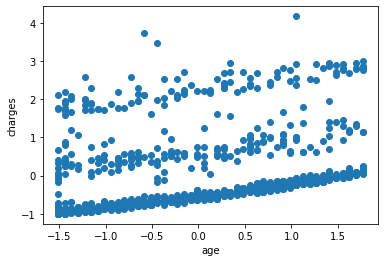

In [114]:
plt.scatter(x1, y)
plt.xlabel("age")
plt.ylabel("charges");

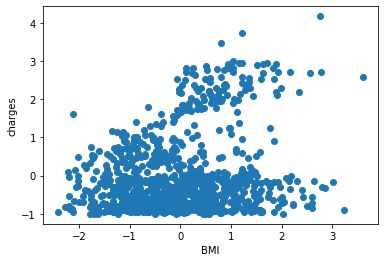

In [115]:
plt.scatter(x2, y)
plt.xlabel("BMI")
plt.ylabel("charges");

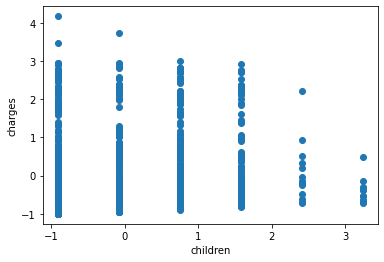

In [116]:
plt.scatter(x3, y)
plt.xlabel("children")
plt.ylabel("charges");

## Build Regression Models

$y = w_{0} + w_{1}x_{1} + w_{2}x_{2} + w_{3}x_{3}$

$x_{1}, x_{2}, x_{3}$ represent the age, bmi and number of children respectively. $ w_{1},w_{2}, w_{3}$ are weights associated with $x_{1}, x_{2}, x_{3}$.

$$X = 
\begin{bmatrix} 
1 & x_{11} & x_{12} & x_{13}\\
1 & x_{21} & x_{22} & x_{23}\\
. & . & . & . \\
. & . & . & . \\
1 & x_{m1} & x_{m2} & x_{m3}\\
\end{bmatrix}
\quad
$$
$$ $$
$$Y = 
\begin{bmatrix} 
y_{1}\\
y_{2}\\
.\\
.\\
y_{m}\\
\end{bmatrix}
\quad
$$ where $m$ = size of training data
$$ $$
$$ω = 
\begin{bmatrix} 
ω_{0}\\
ω_{1}\\
ω_{2}\\
ω_{3}\\
\end{bmatrix}
\quad
$$
$$ $$
$$b = X^{T} . Y$$

$$ ω = (X^{T}.X)^{-1}x^{T}.Y = (X^{T}.X)^{-1}.b$$

In [153]:
class Model:
    def __init__(self, data):
        self.data = data
        self.models = pd.DataFrame(columns = ["w0", "w1", "w2", "w3", "testing_error", "training_error"])
        self.model = np.zeros((4, 1))
        self.min_error = float("inf")
    
    def __shuffle(self):
        self.data = self.data.sample(frac = 1)
    
    def __split(self):
        train = self.data[:int(0.7 * len(data))]
        test = self.data[int(0.7 * len(data)):]
        return train, test

    def __matrices(self, train):
        x1, x2, x3, y = train["age"], train["bmi"], train["children"], train["charges"]
        x1 = np.array(x1)
        x2 = np.array(x2)
        x3 = np.array(x3)
        Y = np.array(y)
        n = len(Y)
        x0 = np.ones((n,1))
        x1 = np.reshape(x1, (n, 1))
        x2 = np.reshape(x2, (n, 1))
        x3 = np.reshape(x3, (n, 1))
        X = np.append(x0, x1, axis=1)
        X = np.append(X, x2, axis=1)
        X = np.append(X, x3, axis=1)
        return X, Y
    
    def __solve(self, X, Y):
        XT = np.transpose(X)
        A = XT.dot(X)
        A_inv = np.linalg.inv(A)
        b = XT.dot(Y)
        w = A_inv.dot(b)
        return w
    
    def __error(self, X, Y, w):
        error = 0
        for i in range(len(X)):
            error += (X[i].dot(w) - Y[i])**2
        error /= 2 * len(Y)
        return error
    
    def __testModel(self, test, w):
        Xt, Yt = self.__matrices(test)
        testing_error = self.__error(Xt, Yt, w)
        return testing_error
    
    def buildModels(self, number = 20):
        for i in range(number):
            self.__shuffle()
            train, test = self.__split()
            X, Y = self.__matrices(train)
            w = self.__solve(X, Y)
            training_error = self.__error(X, Y, w)
            testing_error = self.__testModel(test, w)
            model = list(w)
            model.append(testing_error)
            model.append(training_error)
            model = pd.Series(model, index = self.models.columns)
            self.models = self.models.append(model, ignore_index=True)
            if self.min_error > testing_error:
                self.min_error = testing_error
                self.model = w

In [159]:
final_model = Model(data)
final_model.buildModels()
final_model.models

,w0,w1,w2,w3,testing_error,training_error
0,-0.008596,0.268240,0.175542,0.048271,0.419129,0.448613
1,-0.020551,0.303936,0.117790,0.053750,0.489413,0.420552
2,0.001579,0.284138,0.178974,0.069630,0.440887,0.439395
3,-0.009042,0.300213,0.126653,0.043230,0.473768,0.426469
4,-0.003058,0.312699,0.146619,0.055796,0.454199,0.434405
5,0.000195,0.256981,0.158111,0.059612,0.455812,0.433102
6,-0.036479,0.306883,0.123822,0.052172,0.489847,0.420734
7,0.023667,0.266370,0.167919,0.066794,0.381687,0.465115
8,-0.017718,0.286933,0.153425,0.053801,0.460456,0.431068
9,0.012159,0.270404,0.173188,0.049769,0.429615,0.444104


In [156]:
final_model.models.testing_error.mean()

0.4350534838629222

In [157]:
final_model.models.testing_error.var()

0.0006722991769891268